# Last Edited 02/11/2024 
Do not Edit

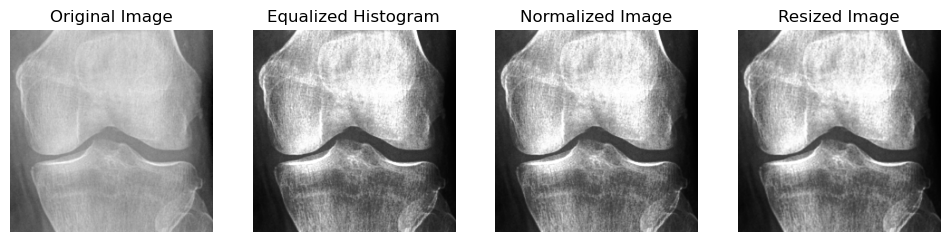

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

class ImagePreprocessor:
    def __init__(self, image_path):
        self.image_path = image_path
        self.original_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    def equalize_histogram(self):
        self.equalized_img = cv2.equalizeHist(self.original_img)
        return self.equalized_img

    def normalize_image(self, image):
        normalized_img = (image - np.min(image)) / (np.max(image) - np.min(image))
        return normalized_img

    def resize_image(self, image, target_size):
        resized_img = np.array(Image.fromarray((image * 255).astype(np.uint8)).resize(target_size))
        return resized_img

    def process_and_display(self):
        # Perform all preprocessing steps
        equalized_img = self.equalize_histogram()
        normalized_img = self.normalize_image(equalized_img)
        resized_img = self.resize_image(normalized_img, (256, 256))

        # Plot the images with headings
        images = [self.original_img, equalized_img, normalized_img, resized_img]
        titles = ['Original Image', 'Equalized Histogram', 'Normalized Image', 'Resized Image']

        plt.figure(figsize=(12, 4))
        for i, (img, title) in enumerate(zip(images, titles)):
            plt.subplot(1, 4, i + 1)
            plt.imshow(img, cmap='gray')
            plt.title(title)
            plt.axis('off')
        
        plt.show()

        return resized_img

# Usage
image_path = 'DATASETS/split_data/train/2/9873823L.png'
preprocessor = ImagePreprocessor(image_path)
final_image = preprocessor.process_and_display()

In [2]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import torch

def process_dataset(dataset_dir):
    X = []
    y = []

    # Count total files for progress bar
    total_files = sum(len(files) for _, _, files in os.walk(dataset_dir))

    with tqdm(total=total_files, unit="images", desc="Preprocessing dataset") as pbar:
        for dirname, _, filenames in os.walk(dataset_dir):
            
            # Check if directory name is numeric, indicating a label folder
            if os.path.basename(dirname).isdigit():
                label = int(os.path.basename(dirname))  # Folder name as the label

                for filename in filenames:
                    image_path = os.path.join(dirname, filename)
                    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

                    # Initialize preprocessor with the image path
                    preprocessor = ImagePreprocessor(image_path)
                    equalized_image = preprocessor.equalize_histogram()
                    normalized_image = preprocessor.normalize_image(equalized_image)
                    resized_image = preprocessor.resize_image(normalized_image, (256, 256))

                    X.append(resized_image)
                    y.append(label)

                    pbar.update(1)
        # Convert lists to NumPy arrays first
        X_array = np.array(X)  # Convert to NumPy array
        y_array = np.array(y)
        # Convert lists to PyTorch tensors
        X_tensor = torch.tensor(X_array).float()  # Convert to float tensor
        y_tensor = torch.tensor(y_array).long()   # Convert to long tensor for labels
    return X_tensor, y_tensor


In [ ]:
# Usage
dataset_dir = "DATASETS/split_data/train/"
X_train, y_train = process_dataset(dataset_dir)

In [ ]:
dataset_dir = "DATASETS/OSAIL_KL_Dataset/Labeled/"
X_val, y_val = process_dataset(dataset_dir)

In [3]:
dataset_dir = "DATASETS/split_data/test/"
X_test, y_test = process_dataset(dataset_dir)

Preprocessing dataset: 100%|██████████| 1526/1526 [00:02<00:00, 706.09images/s]


In [ ]:
import matplotlib.pyplot as plt

# Plot random images with labels to check preprocessing
num_samples = 5
plt.figure(figsize=(15, 3))
for i in range(num_samples):
    idx = np.random.randint(0, len(X_train))
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(X_train[idx], cmap='gray')
    plt.title(f"Label: {y_train[idx]}")
    plt.axis('off')
plt.show()


In [ ]:
import collections
import numpy as np

# Convert the PyTorch tensor to a NumPy array
y_train_np = y_train.numpy()

# Count the occurrences of each label
label_counts = collections.Counter(y_train_np)

# Print the label distribution
print("Label distribution:", label_counts)



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import torchsummary
import numpy as np

class LightweightMedicalCNN(nn.Module):
    def __init__(self, num_classes, in_channels=1):
        super(LightweightMedicalCNN, self).__init__()
        
        # Initial parameters
        self.in_channels = in_channels
        self.num_classes = num_classes
        
        # First Convolutional Block
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        # Second Convolutional Block with Primary Caps inspiration
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        # Third Convolutional Block
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        # Spatial Attention Module
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(128, 1, kernel_size=7, padding=3),
            nn.Sigmoid()
        )
        
        # Dynamic Routing inspired module
        self.caps_layer = nn.Sequential(
            nn.Conv2d(128, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4))
        )
        
        # Calculate the size for the flatten layer
        self._to_linear = 16 * 4 * 4
        
        # Classification layers
        self.classifier = nn.Sequential(
            nn.Linear(self._to_linear, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
        # Initialize weights
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # First block
        x = self.conv1(x)
        
        # Second block
        x = self.conv2(x)
        
        # Third block
        x = self.conv3(x)
        
        # Apply spatial attention
        attention = self.spatial_attention(x)
        x = x * attention
        
        # Capsule inspired feature extraction
        x = self.caps_layer(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Classification
        x = self.classifier(x)
        
        return x

def print_model_summary(model, input_size=(1, 256, 256)):
    """
    Print model summary and calculate model size
    """
    # Convert input size to include batch dimension
    batch_size = 1
    input_shape = (batch_size, *input_size)
    
    # Create dummy input
    dummy_input = torch.randn(input_shape)
    
    # Print model architecture
    print("\nModel Architecture:")
    print(model)
    
    # Calculate total parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"\nTotal Parameters: {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")
    
    # Estimate model size in MB
    model_size_mb = total_params * 4 / (1024 * 1024)  # Assuming 4 bytes per parameter
    print(f"Estimated Model Size: {model_size_mb:.2f} MB")
    
    # Test forward pass
    try:
        output = model(dummy_input)
        print(f"\nInput Shape: {input_shape}")
        print(f"Output Shape: {output.shape}")
        print("\nModel summary test passed successfully!")
    except Exception as e:
        print(f"\nError during forward pass: {str(e)}")

# Example usage
def test_model(num_classes=5):
    """
    Test the model with sample data
    """
    # Initialize model
    model = LightweightMedicalCNN(num_classes=num_classes, in_channels=1)
    
    # Print model summary
    print_model_summary(model)
    
    return model

In [ ]:
if __name__ == "__main__":
    # Test with 5 classes
    model = test_model(num_classes=5)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler
import wandb
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd
from typing import Dict, Tuple
import os
from datetime import datetime

In [6]:
class CustomDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray, transform=None):
        self.X = torch.FloatTensor(X).unsqueeze(1)  # Add channel dimension
        self.y = torch.LongTensor(y)
        self.transform = transform

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        if self.transform:
            return self.transform(self.X[idx]), self.y[idx]
        return self.X[idx], self.y[idx]

In [7]:

def evaluate_model(
    model: nn.Module,
    test_loader: DataLoader,
    device: str = None,
    save_path: str = None
):
    """Evaluate model on test set and generate detailed metrics"""
    device = device or torch.device("cuda")
    model = model.to(device)
    model.eval()
    
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc='Testing'):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    # Generate classification report
    report = classification_report(all_targets, all_preds, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    
    # Plot confusion matrix
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(12,10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Test Set Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    if save_path:
        # Save results
        plt.savefig(os.path.join(save_path, 'confusion_matrix.png'))
        report_df.to_csv(os.path.join(save_path, 'classification_report.csv'))
    
    plt.show()
    print("\nClassification Report:")
    print(report_df)
    
    return report_df, cm

In [ ]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0, mode='min'):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, current_val):
        if self.best_loss is None:
            self.best_loss = current_val
        elif current_val > self.best_loss + self.min_delta and self.mode == 'min':
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = current_val
            self.counter = 0

class Trainer:
    def __init__(
        self,
        model: nn.Module,
        config: Dict,
        train_loader: DataLoader,
        val_loader: DataLoader,
        criterion: nn.Module = None,
        optimizer: optim.Optimizer = None,
        scheduler = None,
        device: str = None
    ):
        self.config = config
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion or nn.CrossEntropyLoss()
        self.optimizer = optimizer or optim.AdamW(
            model.parameters(),
            lr=config['learning_rate'],
            weight_decay=config['weight_decay']
        )
        self.scheduler = scheduler or optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', patience=3, factor=0.1
        )
        self.device = device or torch.device("cuda")
        self.model = self.model.to(self.device)
        self.scaler = GradScaler('cuda')
        self.early_stopping = EarlyStopping(patience=config['early_stopping_patience'])
        
        # Initialize metrics tracking
        self.best_val_loss = float('inf')
        self.best_val_acc = 0.0
        
        # Setup WandB
        self.run = wandb.init(
            project=config['project_name'],
            config=config,
            name=f"{config['model_name']}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
        )
        
        # Save paths
        self.save_dir = config['save_dir']
        os.makedirs(self.save_dir, exist_ok=True)
        
    def train_epoch(self) -> Tuple[float, float]:
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        pbar = tqdm(self.train_loader, desc='Training')
        for batch_idx, (inputs, targets) in enumerate(pbar):
            inputs, targets = inputs.to(self.device), targets.to(self.device)
            
            self.optimizer.zero_grad()
            
            # Mixed precision training
            with autocast('cuda'):
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
            
            # Backward pass with gradient scaling
            self.scaler.scale(loss).backward()
            self.scaler.step(self.optimizer)
            self.scaler.update()
            
            # Metrics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            # Update progress bar
            pbar.set_postfix({
                'loss': running_loss/(batch_idx+1),
                'acc': 100.*correct/total
            })
            
        epoch_loss = running_loss / len(self.train_loader)
        epoch_acc = 100. * correct / total
        return epoch_loss, epoch_acc
    
    def validate_epoch(self) -> Tuple[float, float]:
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            pbar = tqdm(self.val_loader, desc='Validation')
            for batch_idx, (inputs, targets) in enumerate(pbar):
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
                
                all_preds.extend(predicted.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())
                
                pbar.set_postfix({
                    'loss': running_loss/(batch_idx+1),
                    'acc': 100.*correct/total
                })
        
        epoch_loss = running_loss / len(self.val_loader)
        epoch_acc = 100. * correct / total
        
        # Log confusion matrix to WandB
        cm = confusion_matrix(all_targets, all_preds)
        plt.figure(figsize=(10,8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Validation Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        wandb.log({"confusion_matrix": wandb.Image(plt)})
        plt.close()
        
        return epoch_loss, epoch_acc
    
    def train(self, epochs: int):
        for epoch in range(epochs):
            print(f'\nEpoch {epoch+1}/{epochs}')
            
            # Training phase
            train_loss, train_acc = self.train_epoch()
            
            # Validation phase
            val_loss, val_acc = self.validate_epoch()
            
            # Learning rate scheduling
            self.scheduler.step(val_loss)
            current_lr = self.optimizer.param_groups[0]['lr']
            
            # Logging
            wandb.log({
                "train_loss": train_loss,
                "train_acc": train_acc,
                "val_loss": val_loss,
                "val_acc": val_acc,
                "learning_rate": current_lr
            })
            
            # Save best model
            if val_acc > self.best_val_acc:
                self.best_val_acc = val_acc
                self.save_model('best_model.pth')
            
            # Early stopping check
            self.early_stopping(val_loss)
            if self.early_stopping.early_stop:
                print("Early stopping triggered")
                break
        
        # Save final model
        self.save_model('final_model.pth')
        self.run.finish()
    
    def save_model(self, filename: str):
        """Save model with config and metrics"""
        save_path = os.path.join(self.save_dir, filename)
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'config': self.config,
            'best_val_acc': self.best_val_acc,
            'best_val_loss': self.best_val_loss
        }, save_path)
        wandb.save(save_path)

# Example usage
def main():
    # Configuration
    config = {
        'project_name': 'image_classification',
        'model_name': 'EnhancedXRayClassifier',
        'learning_rate': 5e-4,
        'weight_decay': 1e-2,
        'batch_size': 28,
        'early_stopping_patience': 4,
        'save_dir': './models',
        'num_epochs': 100
    }
    
    # Create datasets
    train_dataset = CustomDataset(X_train, y_train)
    val_dataset = CustomDataset(X_val, y_val)
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=config['batch_size'],
        shuffle=True,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=config['batch_size'],
        shuffle=False,
    )
    
    # Initialize model and trainer
    model = LightweightMedicalCNN(num_classes=5)  # Your model class
    trainer = Trainer(
        model=model,
        config=config,
        train_loader=train_loader,
        val_loader=val_loader
    )

    # Train model
    trainer.train(epochs=config['num_epochs'])

if __name__ == "__main__":
    main()

/tmp/ipykernel_461670/2289569562.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('./models/best_model.pth')


Testing:   0%|          | 0/1526 [00:00<?, ?it/s]

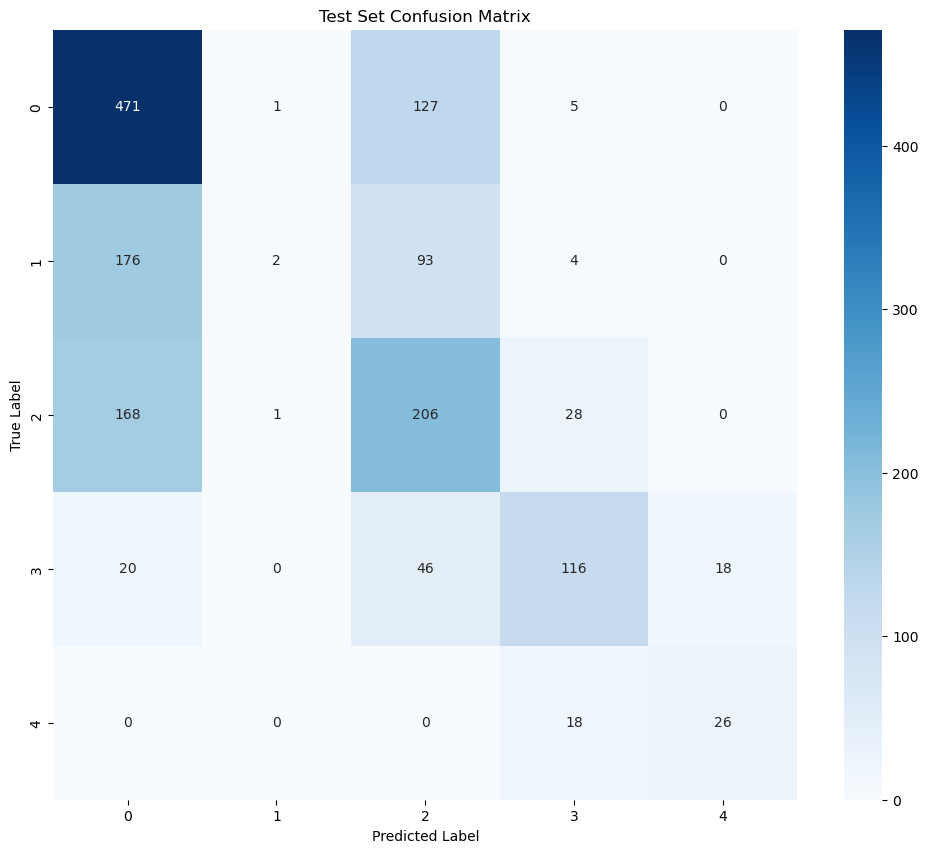


Classification Report:
              precision    recall  f1-score      support
0              0.564072  0.779801  0.654621   604.000000
1              0.500000  0.007273  0.014337   275.000000
2              0.436441  0.511166  0.470857   403.000000
3              0.678363  0.580000  0.625337   200.000000
4              0.590909  0.590909  0.590909    44.000000
accuracy       0.538008  0.538008  0.538008     0.538008
macro avg      0.553957  0.493830  0.471212  1526.000000
weighted avg   0.534572  0.538008  0.485031  1526.000000


In [8]:
# Create test dataset and loader
test_dataset = CustomDataset(X_test, y_test)
test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=1
)
model = LightweightMedicalCNN(num_classes=5)
# Load best model
checkpoint = torch.load('./models/best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
device = torch.device("cpu")
model = model.to(device)

# Evaluate
report_df, confusion_matrix = evaluate_model(
    model,
    test_loader,
    save_path='./results'
)